<a href="https://colab.research.google.com/github/wheemin-2/25-1-ESAA/blob/main/OBproject_%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C_%EC%B5%9C%EC%A2%85%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import hstack, csr_matrix
from gensim.models import Word2Vec

# **애니메이션 데이터 전처리**

애니메이션 데이터 : https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020?select=watching_status.csv

## animelist 데이터 샘플링

데이터 크기가 너무 커 데이터를 불러오는 과정에서 문제 발생, 샘플링 필요성 확인

`sample()` 메서드를 활용하여 랜덤 샘플링 진행 > 데이터의 크기를 줄임

‼️random_state 설정 + csv 파일로 추출하여 모두가 공유하기‼️

In [ ]:
anime_list = pd.read_csv('/content/drive/MyDrive/ESAA_OB_FINAL_PROJECT/animelist.csv')
anime_list = anime_list.sample(frac=0.1, random_state=2025)

# 샘플링 결과 확인 (1억개 > 1천만개)
print(anime_list.shape)
anime_list.head()

(10922475, 5)


,user_id,anime_id,rating,watching_status,watched_episodes
78670575,254726,19815,9,2,12
32398745,105137,16009,0,3,6
31831944,103214,2494,8,2,12
107966781,349325,6880,8,2,12
25758766,83513,853,9,2,26


In [ ]:
len(anime_list['user_id'].unique()) # user 35만명 > 31만명

313097

In [ ]:
anime = pd.read_csv('/content/drive/MyDrive/ESAA_OB_FINAL_PROJECT/anime.csv')
anime_with_synopsis = pd.read_csv('/content/drive/MyDrive/ESAA_OB_FINAL_PROJECT/anime_with_synopsis.csv')

anime_list 전처리
- 시놉시스 없는 행 drop ✅
- watching_status 이상치 지우기 (> 1,2,3,4,6 만 남기기) ✅
- watching_status==6 이면서 평점이 있는 거 지우기
- watching_status==6 이면서 평점이 0인 값을 어떻게 처리할 건지?
    - 해당 애니메이션의 기존 평점으로 대체 (anime.Score 값)
- rating이 0인 값이 약 2천만개 > 확인필요, 어떻게 처리할 것인가

가중 평점 정의
- wating_status, watched_episodes 정보 반영

anime_with_synopsis
- synopsis 칼럼명 오타


## **anime_list 전처리**

### 시놉시스 없는 행 제거

In [ ]:
anime_list.shape

(10922475, 5)

In [ ]:
# 시놉시스가 있는 애니메이션 목록
anime_list[anime_list['anime_id'].isin(anime_with_synopsis['MAL_ID'])]

,user_id,anime_id,rating,watching_status,watched_episodes
78670575,254726,19815,9,2,12
32398745,105137,16009,0,3,6
31831944,103214,2494,8,2,12
107966781,349325,6880,8,2,12
25758766,83513,853,9,2,26
...,...,...,...,...,...
40770528,132208,2924,10,2,12
37961299,123235,1535,8,2,35
24687481,80054,223,10,2,153
93335929,301564,14813,8,2,13


In [ ]:
# 시놉시스가 없는 애니메이션 개수 (약 19만개)
len(anime_list[~anime_list['anime_id'].isin(anime_with_synopsis['MAL_ID'])])

194352

In [ ]:
# 시놉시스가 있는 애니메이션만 남기고 확인
anime_list = anime_list[anime_list['anime_id'].isin(anime_with_synopsis['MAL_ID'])]
anime_list.shape

(10728123, 5)

### watching_status 이상치 제거

*sampling 과정에서 55,33과 같은 이상치가 제거됨

In [ ]:
anime_list['watching_status'].value_counts()

,count
watching_status,
2,6683508
6,2749075
1,512791
4,421679
3,361029
0,40
5,1


In [ ]:
normal_status = [1,2,3,4,6]
len(anime_list[~anime_list['watching_status'].isin(normal_status)]) # 이상치 개수 96개

41

In [ ]:
# 이상치 제거 후 확인
anime_list.drop(anime_list[~anime_list['watching_status'].isin(normal_status)].index, axis=0, inplace=True)
anime_list['watching_status'].value_counts()

,count
watching_status,
2,6683508
6,2749075
1,512791
4,421679
3,361029


### watching_status 이상치 제거 2

1. watching_status==6 : Plan to Watch 이면서 평점이 있는 거 지우기

2. watching_status==6 이면서 평점이 0인 값을 어떻게 처리할 건지?
    - 해당 애니메이션의 기존 평점으로 대체 (anime.Score 값)

In [ ]:
# 대부분은 평점이 0, 하지만 최댓값이 10임 >> outlier, 제거
anime_list[anime_list['watching_status']==6]['rating'].describe()

,rating
count,2.749075e+06
mean,7.652865e-02
std,7.964490e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+01


In [ ]:
print(len(anime_list[(anime_list['watching_status']==6)&(anime_list['rating']!=0)])) # 이상치 개수 확인 (약 2.5만개)

# 이상치 제거 진행
anime_list.drop(anime_list[(anime_list['watching_status']==6)&(anime_list['rating']!=0)].index,
                axis=0, inplace=True)

26797


In [ ]:
# Plan to Watch 인 행의 평점(=0)을 해당 애니메이션의 평균 평점으로 대체
display(anime_list[(anime_list['watching_status']==6)])

# anime, anime_list 병합
temp1 = anime[['MAL_ID','Score']]
temp2 = pd.merge(anime_list, temp1, left_on='anime_id', right_on='MAL_ID', how='left')
sum(temp2['Score'].isna())  # 병합 후 Score에 NaN 값 있는지 확인

,user_id,anime_id,rating,watching_status,watched_episodes
14801589,48053,16870,0,6,1
36741226,119310,10030,0,6,0
39679618,128900,32366,0,6,0
93232121,301204,2001,0,6,0
62833520,203560,19117,0,6,0
...,...,...,...,...,...
43529574,141201,5,0,6,0
71798880,232328,25099,0,6,0
86069125,278261,10495,0,6,0
64880896,210018,24261,0,6,0


0

In [ ]:
# Plan to Watch의 rating을 전체 평점으로 대체
temp2.loc[temp2['watching_status']==6,'rating'] = temp2.loc[temp2['watching_status']==6,'Score']
temp2[temp2['watching_status']==6][['rating', 'Score']]

/tmp/ipython-input-223623296.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['7.76' '8.4' '8.41' ... '7.6' '7.02' '9.19']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  temp2.loc[temp2['watching_status']==6,'rating'] = temp2.loc[temp2['watching_status']==6,'Score']


,rating,Score
5,7.76,7.76
6,8.4,8.4
9,8.41,8.41
10,8.66,8.66
11,7.19,7.19
...,...,...
10701246,8.39,8.39
10701250,6.81,6.81
10701257,7.6,7.6
10701262,7.02,7.02


In [ ]:
# 병합에 쓰인 anime 데이터셋 칼럼 drop
temp2.drop(columns=['MAL_ID','Score'], inplace=True)

### **전처리 된 anime_list csv 파일로 저장**

In [ ]:
anime_list = temp2.copy()
anime_list.to_csv('animelist_df.csv', index=False)

### rating이 0인 값 처리 (시각화)

[Watching_Status]

1 : Currently Watching

2 : Completed

3 : On Hold

4 : Dropped

6 : Plan to Watch

1867905


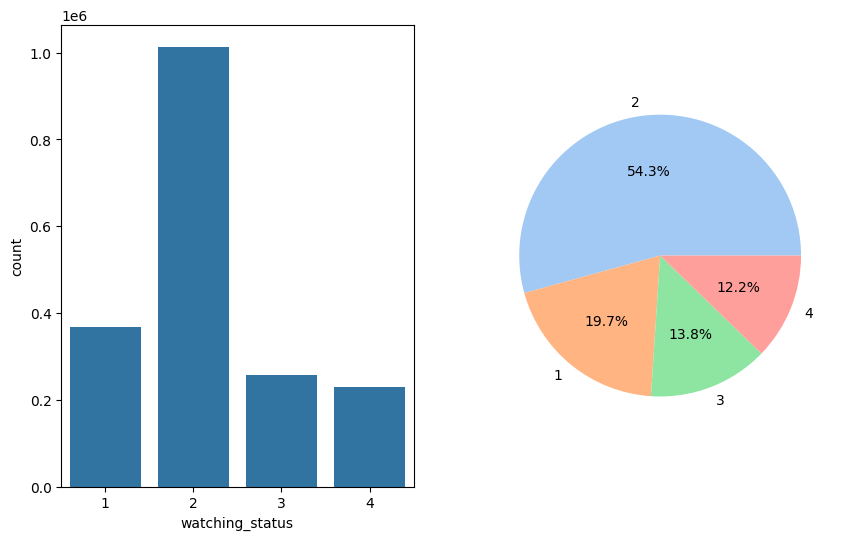

In [ ]:
print(len(temp2[temp2['rating']==0]))   # 0점 개수 : 약 18만개

fig, ax = plt.subplots(figsize=(10,6), ncols=2)
sns.barplot(temp2[temp2['rating']==0]['watching_status'].value_counts(), ax=ax[0])
ax[1] = plt.pie(x = temp2[temp2['rating']==0]['watching_status'].value_counts(),
                labels = temp2[temp2['rating']==0]['watching_status'].value_counts().index,
                colors = sns.color_palette('pastel')[0:5], autopct='%.1f%%')

In [ ]:
# watching_status 이상치 처리 후 전체 rating 분포 확인
temp3 = temp2.copy()
temp3['rating'] = pd.to_numeric(temp2['rating'], errors='coerce')
temp3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10701285 entries, 0 to 10701284
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           int64  
 1   anime_id          int64  
 2   rating            float64
 3   watching_status   int64  
 4   watched_episodes  int64  
dtypes: float64(1), int64(4)
memory usage: 408.2 MB


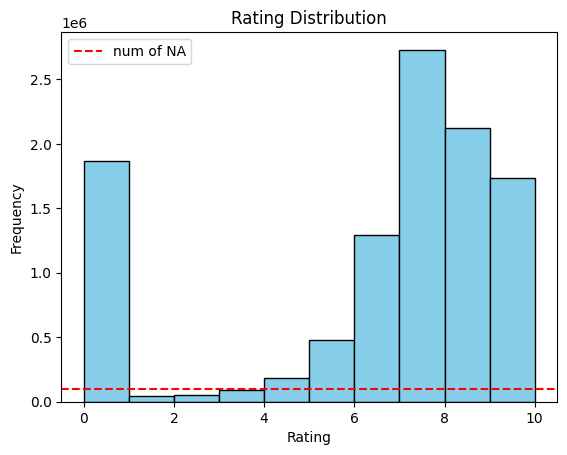

In [ ]:
plt.hist(temp3['rating'].dropna(), bins=10, color='skyblue', edgecolor='black')

na_count = temp3['rating'].isna().sum()
plt.axhline(y=na_count, color='red', linestyle='--', label='num of NA')

plt.legend()
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution')
plt.show()

## **anime_with_synopsis 전처리**

칼럼명 오타 수정

sypnopsis -> synopsis

In [ ]:
anime_with_synopsis

,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...
...,...,...,...,...,...
16209,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",No synopsis information has been added to this...
16210,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",ko is a typical high school student whose life...
16211,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Sequel to Higurashi no Naku Koro ni Gou .
16212,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",New Yama no Susume anime.


In [ ]:
# 칼럼명 오타 수정
anime_with_synopsis.rename(columns={'sypnopsis':'synopsis'}, inplace=True)
anime_with_synopsis

,MAL_ID,Name,Score,Genres,synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...
...,...,...,...,...,...
16209,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",No synopsis information has been added to this...
16210,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",ko is a typical high school student whose life...
16211,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Sequel to Higurashi no Naku Koro ni Gou .
16212,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",New Yama no Susume anime.


## **anime 전처리**

필요한 칼럼만 남기기

In [ ]:
print(anime.columns)
anime.head()

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [ ]:
# 필요한 칼럼만 남기기
anime = anime[['MAL_ID','Score','Genres','English name','Episodes']]
anime.head()

,MAL_ID,Score,Genres,English name,Episodes
0,1,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,26
1,5,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,1
2,6,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,26
3,7,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,26
4,8,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,52


---
2차 전처리

---

## anime - Genres

1. 장르 문자열 분해\
    "Action, Drama, Sci-Fi"처럼 쉼표로 구분된 장르를 분할해서 리스트로 변환

2. 소문자화 및 공백 제거\
    일관성을 위해 모든 장르명을 소문자로 변환하고 공백 제거

3. 오타 및 유사 장르 정리 (대표 장르로 매핑)\
    sci-fi → science fiction, shoujo ai → shoujo, harem → romance 같은 식으로 통합

4. 대표 장르 기준으로 다시 문자열 조합\
    다시 쉼표로 연결된 문자열로 저장하거나, 리스트 형태로 둘 수도 있음

In [ ]:
# 장르 분해해서 전체 목록 만들기
# NaN 제거 후 장르 나누기
genre_list = anime['Genres'].dropna().apply(lambda x: [g.strip().lower() for g in x.split(',')])
flat_genre_list = [genre for sublist in genre_list for genre in sublist]

# 고유 장르 목록 확인
genre_counter = Counter(flat_genre_list)

# 많이 등장하는 순으로 정렬해서 보기
genre_df = pd.DataFrame(genre_counter.items(), columns=['genre', 'count']).sort_values(by='count', ascending=False)
display(genre_df)

,genre,count
2,comedy,6029
0,action,3888
11,fantasy,3285
1,adventure,2957
38,kids,2665
3,drama,2619
4,sci-fi,2583
35,music,2244
7,shounen,2003
15,slice of life,1914


-> 너무 많음. 대표 장르로 매핑해서 장르 수를 줄이자!

ex. yaoi(남성 간의 사랑), yuri(여성 간의 사랑) 등은 다 Romance로 분류함.

In [ ]:
# 장르 분해 및 소문자화, 공백 제거
anime['Genres_list'] = anime['Genres'].str.lower().str.replace(' ', '').str.split(',')

# 대표 장르 매핑 사전 + adult 장르 병합
genre_map = {
    'sci-fi': 'science fiction',
    'space': 'science fiction',
    'superpower': 'fantasy',
    'super power': 'fantasy',
    'shounenai': 'romance',
    'shoujoai': 'romance',
    'yaoi': 'romance',
    'yuri': 'romance',
    'harem': 'romance',
    'josei': 'drama',
    'shoujo': 'drama',
    'shounen': 'action',
    'seinen': 'drama',
    'cars': 'sports',
    'sports': 'sports',
    'mecha': 'action',
    'martialarts': 'action',
    'military': 'action',
    'police': 'action',
    'demons': 'horror',
    'vampire': 'horror',
    'sliceoflife': 'documentary',
    'school': 'drama',
    'dementia': 'psychological',
    'game': 'fantasy',
    'magic': 'fantasy',
    'parody': 'comedy',
    'hentai': 'adult',
    'ecchi': 'adult',
    'unknown': None  # 제거
}


# 장르 정리 함수
def clean_genres(genre_list):
    cleaned = []
    for g in genre_list:
        g = g.strip()
        g = genre_map.get(g, g)  # 매핑 없으면 원래 값 유지
        if g and g not in cleaned:
            cleaned.append(g)
    return cleaned

# 적용
anime['cleaned_genres'] = anime['Genres_list'].apply(clean_genres)

# Genres에 전처리 결과 덮어쓰기
anime['Genres'] = anime['cleaned_genres']

# 불필요한 열 제거
anime.drop(columns=['Genres_list', 'cleaned_genres'], inplace=True)

# 확인
anime.head()

,MAL_ID,Score,Genres,English name,Episodes
0,1,8.78,"[action, adventure, comedy, drama, science fic...",Cowboy Bebop,26
1,5,8.39,"[action, drama, mystery, science fiction]",Cowboy Bebop:The Movie,1
2,6,8.24,"[action, science fiction, adventure, comedy, d...",Trigun,26
3,7,7.27,"[action, mystery, supernatural, drama, fantasy]",Witch Hunter Robin,26
4,8,6.98,"[adventure, fantasy, action, supernatural]",Beet the Vandel Buster,52


In [ ]:
# 리스트 형태의 Genres 열을 다시 펼치고, 개수 세기
genre_counts = pd.Series([g for sublist in anime['Genres'] for g in sublist]).value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# 결과 확인
genre_counts

,genre,count
0,comedy,6142
1,action,5549
2,drama,4897
3,fantasy,4434
4,adventure,2957
5,kids,2665
6,science fiction,2651
7,music,2244
8,romance,2180
9,adult,2115


-> 장르 약 17개로 정리 완료

---

## anime_with_synopsis - Genres

장르명을 모두 소문자화 및 공백 제거

오타 및 유사 장르 통합

ecchi, hentai, yaoi, yuri, shounen ai, shoujo ai → 'adult'로 통합

In [ ]:
# NaN 제거 후 장르 문자열을 소문자화하고 ','로 분리
genre_list = anime_with_synopsis['Genres'].dropna().apply(
    lambda x: [g.strip().lower() for g in x.split(',')]
)

# 리스트 평탄화 (flatten)
flat_genre_list = [genre for sublist in genre_list for genre in sublist]

# 장르별 등장 횟수 계산
genre_counter = Counter(flat_genre_list)

# 많이 등장한 순서대로 DataFrame 생성
genre_df = pd.DataFrame(genre_counter.items(), columns=['genre', 'count']).sort_values(by='count', ascending=False)

# 결과 출력
display(genre_df)

,genre,count
2,comedy,5975
0,action,3846
11,fantasy,3202
1,adventure,2942
38,kids,2665
3,drama,2589
4,sci-fi,2551
35,music,2241
7,shounen,2003
15,slice of life,1912


In [ ]:
# 정리할 대표 장르 매핑
genre_map = {
    'sci-fi': 'science fiction',
    'space': 'science fiction',
    'superpower': 'fantasy',
    'super power': 'fantasy',
    'shounenai': 'romance',
    'shoujoai': 'romance',
    'yaoi': 'romance',
    'yuri': 'romance',
    'harem': 'romance',
    'josei': 'drama',
    'shoujo': 'drama',
    'shounen': 'action',
    'seinen': 'drama',
    'cars': 'sports',
    'sports': 'sports',
    'mecha': 'action',
    'martialarts': 'action',
    'thriller': 'horror',
    'demons': 'horror',
    'psychological': 'drama',
    'military': 'action',
    'police': 'action',
    'sliceoflife': 'drama',
    'school': 'drama',
    'parody': 'comedy',
    'vampire': 'horror',
    'dementia': 'psychological',
    'game': 'fantasy',
    'magic': 'fantasy',
    'unknown': None,  # 제거
    # 새롭게 추가: 성인 요소 → adult로 통합
    'ecchi': 'adult',
    'hentai': 'adult',
    'yaoi': 'adult',
    'yuri': 'adult',
    'shounenai': 'adult',
    'shoujoai': 'adult',
}

# 전처리 함수
def clean_genres(genres_str):
    if pd.isna(genres_str):
        return []
    genres = [g.strip().lower().replace(" ", "") for g in genres_str.split(',')]
    cleaned = []
    for g in genres:
        mapped = genre_map.get(g, g)
        if mapped and mapped not in cleaned:
            cleaned.append(mapped)
    return cleaned

# 적용
anime_with_synopsis['Genres'] = anime_with_synopsis['Genres'].apply(clean_genres)

# 확인용: 장르별 등장 횟수 출력

all_genres = [genre for genres in anime_with_synopsis['Genres'] for genre in genres]
genre_count = Counter(all_genres)
genre_df = pd.DataFrame(genre_count.items(), columns=['genre', 'count']).sort_values(by='count', ascending=False)
display(genre_df)

,genre,count
2,comedy,6085
3,drama,5983
0,action,5499
7,fantasy,4336
1,adventure,2942
16,kids,2665
4,science fiction,2618
15,music,2241
9,romance,1953
6,supernatural,1410


In [ ]:
anime_with_synopsis.head()

,MAL_ID,Name,Score,Genres,synopsis
0,1,Cowboy Bebop,8.78,"[action, adventure, comedy, drama, science fic...","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"[action, drama, mystery, science fiction]","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"[action, science fiction, adventure, comedy, d...","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"[action, mystery, supernatural, drama, fantasy]",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"[adventure, fantasy, action, supernatural]",It is the dark century and the people are suff...


* 장르를 유연하게 활용하기 위해 둘 다 리스트 형태로 변환했으나, 필요에 따라 문자열로 재변환 가능 (예: TF-IDF나 임베딩용)

```python
# 리스트를 문자열로 변환
anime_with_synopsis_df['genre_text'] = anime_with_synopsis_df['Genres'].apply(lambda x: ' '.join(x))

```

---

## anime_with_synopsis - synopsis

| 단계         | 설명               | 예시                                                  |
| ---------- | ---------------- | --------------------------------------------------- |
| 1. 소문자화    | 대소문자 구분 없이 처리하려고 | "The World" → "the world"                           |
| 2. 특수문자 제거 | 의미 없는 기호 제거      | "He’s #1!!" → "Hes 1"                               |
| 3. 토큰화     | 문장을 단어로 나누기      | "the world is big" → \['the', 'world', 'is', 'big'] |
| 4. 불용어 제거  | 의미 없는 단어 제거      | \['the', 'world', 'is'] → \['world']                |

In [ ]:
import re

def clean_text(text):
    text = text.lower()  # 소문자화
    text = re.sub(r'[^a-z\s]', '', text)  # 알파벳과 공백 제외 제거
    return text

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# 필요한 리소스 다운로드 (최초 1회만 실행)
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)  # 토큰화
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# 전처리 함수 통합
def preprocess_synopsis(text):
    if pd.isna(text):
        return []  # 결측치 처리
    cleaned = clean_text(text)
    tokens = tokenize_and_remove_stopwords(cleaned)
    return tokens

# 적용
anime_with_synopsis['cleaned_synopsis'] = anime_with_synopsis['synopsis'].apply(preprocess_synopsis)

# cleaned_synopsis 열을 synopsis로 덮어쓰기
anime_with_synopsis['synopsis'] = anime_with_synopsis['cleaned_synopsis']

# cleaned_synopsis 열 제거
anime_with_synopsis.drop(columns=['cleaned_synopsis'], inplace=True)

In [ ]:
# 결과 확인
anime_with_synopsis.head()

,MAL_ID,Name,Score,Genres,synopsis
0,1,Cowboy Bebop,8.78,"[action, adventure, comedy, drama, science fic...","[year, humanity, colonized, several, planets, ..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"[action, drama, mystery, science fiction]","[day, another, bountysuch, life, often, unluck..."
2,6,Trigun,8.24,"[action, science fiction, adventure, comedy, d...","[vash, stampede, man, bounty, head, reason, he..."
3,7,Witch Hunter Robin,7.27,"[action, mystery, supernatural, drama, fantasy]","[ches, individuals, special, powers, like, esp..."
4,8,Bouken Ou Beet,6.98,"[adventure, fantasy, action, supernatural]","[dark, century, people, suffering, rule, devil..."


## anime_list

In [ ]:
# rating 값들 종류와 개수 세기
(anime_list['rating'] == 'Unknown').sum()

np.int64(102202)

In [ ]:
def compute_weighted_score(anime_id):
    row = anime[anime['MAL_ID'] == anime_id]
    if row.empty:
        return 0.0

    # score 컬럼 순서대로 불러오기
    score_cols = [f'Score-{i}' for i in range(1, 11)]
    try:
        scores = row[score_cols].values.flatten().astype(float)
    except:
        return 0.0  # 혹시 문자열 섞여 있으면 실패 방지

    weights = np.arange(1, 11)  # 1~10점
    total_votes = scores.sum()

    if total_votes == 0:
        return 0.0

    return np.dot(scores, weights) / total_votes

In [ ]:
# rating을 문자열로 변환 (타입 충돌 방지)
anime_list['rating'] = anime_list['rating'].astype(str)

# anime_df에 존재하는 anime_id만 대상으로 평균 점수 계산해서 넣기
mask = (anime_list['rating'] == 'Unknown') & (anime_list['anime_id'].isin(anime['MAL_ID']))
anime_list.loc[mask, 'rating'] = anime_list.loc[mask, 'anime_id'].apply(compute_weighted_score)

# 혹시 남아있는 Unknown은 0으로 대체
anime_list['rating'] = anime_list['rating'].replace('Unknown', 0)

# float64로 변환
anime_list['rating'] = anime_list['rating'].astype('float64')

In [ ]:
print("남은 Unknown 개수:", (anime_list['rating'] == 'Unknown').sum())
print("rating 자료형:", anime_list['rating'].dtype)

남은 Unknown 개수: 0
rating 자료형: float64


In [ ]:
anime_list.head()

,user_id,anime_id,rating,watching_status,watched_episodes
0,254726,19815,9.0,2,12
1,105137,16009,0.0,3,6
2,103214,2494,8.0,2,12
3,349325,6880,8.0,2,12
4,83513,853,9.0,2,26


# **Netflix 데이터 전처리**


넷플릭스 데이터 : https://www.kaggle.com/datasets/rahulvyasm/netflix-movies-and-tv-shows

In [ ]:
netflix_titles_df = pd.read_csv("/content/drive/MyDrive/ESAA_OB_FINAL_PROJECT/netflix_titles.csv", encoding='latin1')

netflix_titles_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 전체 칼럼 확인
print(netflix_titles_df.columns.tolist())

['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25']


In [ ]:
# 'Unnamed'로 시작하는 열 제거
netflix_titles_df = netflix_titles_df.loc[:, ~netflix_titles_df.columns.str.startswith('Unnamed')]

netflix_titles_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## netflix_titles_df - description

In [ ]:
# nltk 리소스 다운로드 (처음 1회만)
#nltk.download('punkt')
#nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def preprocess_description(text):
    if pd.isna(text):
        return []

    text = text.lower()  # 소문자화
    text = re.sub(r'[^a-z\s]', '', text)  # 특수문자 제거
    tokens = word_tokenize(text)  # 토큰화
    tokens = [word for word in tokens if word not in stop_words]  # 불용어 제거

    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
netflix_titles_df['cleaned_description'] = netflix_titles_df['description'].apply(preprocess_description)

netflix_titles_df['description'] = netflix_titles_df['cleaned_description']
netflix_titles_df.drop(columns=['cleaned_description'], inplace=True)

In [ ]:
netflix_titles_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"[father, nears, end, life, filmmaker, kirsten,..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","[crossing, paths, party, cape, town, teen, set..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...","[protect, family, powerful, drug, lord, skille..."
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","[feuds, flirtations, toilet, talk, go, among, ..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...","[city, coaching, centers, known, train, indias..."


## netflix_titles_df - listed_in

In [ ]:
# NaN 제거 후 장르 나누기
netflix_genre_list = netflix_titles_df['listed_in'].dropna().apply(lambda x: [g.strip().lower() for g in x.split(',')])
netflix_flat_genre_list = [genre for sublist in netflix_genre_list for genre in sublist]

# 고유 장르 목록 확인
netflix_genre_counter = Counter(netflix_flat_genre_list)

# 많이 등장하는 순으로 정렬해서 보기
netflix_genre_df = pd.DataFrame(netflix_genre_counter.items(), columns=['genre', 'count']).sort_values(by='count', ascending=False)
display(netflix_genre_df)

,genre,count
14,international movies,2752
12,dramas,2427
16,comedies,1674
1,international tv shows,1351
0,documentaries,869
25,action & adventure,859
2,tv dramas,763
13,independent movies,756
11,children & family movies,641
19,romantic movies,616


In [ ]:
genre_map = {
    'sci-fi': 'science fiction',
    'dramas' : 'drama',
    'comedies' : 'comedy',
    'documentaries' : 'documentary',
    'action & adventure' : 'action',
    'tv dramas' : 'drama',
    'independent movies' : 'documentary',   # 독립영화는 다큐멘터리와 비슷한 성격을 띤다고 판단
    'children & family movies' : 'kids',
    'international movies' : 'international',
    'international tv shows':'international',
    'romantic movies':'romance',
    'tv comedies' : 'comedy',
    'thrillers' : 'thriller',
    'crime tv shows':'horror',
    'kids\' tv'	: 'kids',
    'docuseries':'documentary',
	'music & musicals':	'music',
	'romantic tv shows' : 'romance',
	'horror movies' : 'horror',
	'stand-up comedy' :'comedy',
	'reality tv' : 'comedy'	,
	'sci-fi & fantasy' : 'science fiction',
	'sports movies' : 'sports',
	'anime series' : 'international',
	'spanish-language tv shows' : 'international',
    'tv action & adventure' :'action',
	'korean tv shows' : 'international',
	'tv mysteries' : 'mystery',
	'science & nature tv' : 'documentary',
	'tv sci-fi & fantasy' : 'science fiction',
    'tv horror' : 'horror',
	'anime features' : 'international',
	'cult movies' :'horror',
	'teen tv shows' : 'kids',
	'faith & spirituality' : 'supernatural',
	'tv thrillers' : 'thriller',
	'stand-up comedy & talk shows' : 'comedy',
	'classic & cult tv' : 'horror',
    'classic movies' : None,
	'tv shows' : None,
    'british tv shows' : None,	      # 장르가 명시되지 않은 컨텐츠 : None
    'movies' : None,
	'lgbtq movies' : None}


In [ ]:
# 전처리 함수
def clean_genres(genres_str):
    if pd.isna(genres_str):
        return []
    genres = [g.strip().lower() for g in genres_str.split(',')]
    cleaned = []
    for g in genres:
        mapped = genre_map.get(g, g)
        if mapped and mapped not in cleaned:
            cleaned.append(mapped)
    return cleaned

# 적용
netflix_titles_df['listed_in'] = netflix_titles_df['listed_in'].apply(clean_genres)

# 확인용: 장르별 등장 횟수 출력
from collections import Counter

all_genres = [genre for genres in netflix_titles_df['listed_in'] for genre in genres]
genre_count = Counter(all_genres)
netflix_genre_count = pd.DataFrame(genre_count.items(), columns=['genre', 'count']).sort_values(by='count', ascending=False)
display(netflix_genre_count)

,genre,count
1,international,4220
2,drama,3191
6,comedy,2868
0,documentary,2024
8,kids,1157
5,action,1028
7,romance,987
4,horror,978
9,thriller,635
10,music,375


In [ ]:
# netflix 에만 존재하는 장르가 있는지 확인
print(set(netflix_genre_count.genre.unique())-set(genre_counts.genre.unique()))
# anime_df 에만 존재하는 장르가 있는지 확인
set(genre_counts.genre.unique())-set(netflix_genre_count.genre.unique())

{'international'}


{'adult', 'adventure', 'fantasy', 'historical', 'psychological', 'samurai'}

In [ ]:
# 1. anime (장르 등 전처리 완료)
anime.to_csv('anime_df.csv', index=False)

# 2. anime_list (샘플링, 시놉시스 필터링, watching_status 및 rating 정제 완료)
anime_list.to_csv('animelist_df.csv', index=False)

# 3. anime_with_synopsis (synopsis 열 이름 수정 완료, 필요 열 추출 포함 시)
anime_with_synopsis.to_csv('anime_with_synopsis_df.csv', index=False)

# 4. netflix_titles_df (넷플릭스 데이터)
netflix_titles_df.to_csv('netflix_titles_df.csv', index=False)

In [ ]:
# 데이터프레임 이름 변경
anime_df = anime.copy()
animelist_df = anime_list.copy()
anime_with_synopsis_df = anime_with_synopsis.copy()

# **텍스트 임베딩**

## (1) TF-IDF 변환

### TF-IDF 벡터화: 장르 + 시놉시스 분리 처리

In [ ]:
# 시놉시스: 텍스트로 변환
anime_with_synopsis_df['synopsis_text'] = anime_with_synopsis_df['synopsis'].apply(lambda x: ' '.join(x))
netflix_titles_df['description_text'] = netflix_titles_df['description'].apply(lambda x: ' '.join(x))

# 장르: 공백 없는 단어 리스트를 문자열로 변환
anime_with_synopsis_df['genres_text'] = anime_with_synopsis_df['Genres'].apply(lambda x: ' '.join(x))
netflix_titles_df['genres_text'] = netflix_titles_df['listed_in'].apply(lambda x: ' '.join(x))

# TF-IDF 벡터화
tfidf_genre = TfidfVectorizer(max_features=300)
tfidf_synopsis = TfidfVectorizer(max_features=3000)

anime_genre_vec = tfidf_genre.fit_transform(anime_with_synopsis_df['genres_text'])
anime_synopsis_vec = tfidf_synopsis.fit_transform(anime_with_synopsis_df['synopsis_text'])

netflix_genre_vec = tfidf_genre.transform(netflix_titles_df['genres_text'])  # 동일 vectorizer 사용
netflix_synopsis_vec = tfidf_synopsis.transform(netflix_titles_df['description_text'])


# 최종 콘텐츠 벡터 (장르 + 시놉시스)
anime_content_vec = hstack([anime_genre_vec, anime_synopsis_vec])
netflix_content_vec = hstack([netflix_genre_vec, netflix_synopsis_vec])

In [ ]:
print(anime_content_vec.shape)
print(netflix_content_vec.shape)

(16214, 3020)
(8809, 3020)


### 애니-영화 유사도 행렬 생성

In [ ]:
# 유사도 행렬 생성
sim_matrix = cosine_similarity(anime_content_vec, netflix_content_vec)
sim_matrix.shape

(16214, 8809)

In [ ]:
# 영화 이름을 칼럼명으로 하여 해석을 용이하게 함
similarities = pd.DataFrame(sim_matrix, index=anime_with_synopsis_df['MAL_ID'], columns=netflix_titles_df['title'])
similarities.head()

title,Dick Johnson Is Dead,Blood & Water,Ganglands,Jailbirds New Orleans,Kota Factory,Midnight Mass,My Little Pony: A New Generation,Sankofa,The Great British Baking Show,The Starling,...,Zenda,Zindagi Gulzar Hai,Zinzana,Zodiac,Zombie Dumb,Zombieland,Zoom,Zubaan,Parasyte: The Grey,Serena
MAL_ID,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.087115,0.092303,0.094232,0.087964,0.066900,0.011058,0.121555,0.173350,0.267951,...,0.191058,0.153278,0.082219,0.076082,0.127547,0.094374,0.100193,0.135109,0.318687,0.058443
5,0.010526,0.359988,0.088065,0.000000,0.021507,0.276455,0.000000,0.098554,0.000000,0.133377,...,0.170808,0.099000,0.060800,0.051542,0.045826,0.000000,0.006863,0.101965,0.262406,0.054371
6,0.033940,0.087115,0.081238,0.087539,0.096122,0.066900,0.000000,0.123755,0.164021,0.268001,...,0.192108,0.106414,0.083540,0.055402,0.094579,0.093232,0.135086,0.126354,0.282057,0.075089
7,0.000000,0.354631,0.074454,0.000000,0.000000,0.272341,0.000000,0.097087,0.013325,0.125485,...,0.209161,0.097526,0.086348,0.050775,0.000000,0.000000,0.000000,0.100447,0.055233,0.053562
8,0.027484,0.000000,0.091243,0.019706,0.018825,0.041975,0.000000,0.000000,0.000000,0.005498,...,0.000000,0.000000,0.000000,0.000000,0.016424,0.000000,0.006293,0.010926,0.067688,0.000000


### 사용자 평점 기반 영화 추천 알고리즘 구현


In [ ]:
# watching_status 이상치 처리 과정에서 'Unknown'값이 생김 > 0으로 대체
animelist_df.loc[animelist_df['rating']=='Unknown','rating']=0
animelist_df['rating'] = animelist_df['rating'].astype('float64') # 데이터 형변환
animelist_df['rating'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 10701285 entries, 0 to 10701284
Series name: rating
Non-Null Count     Dtype  
--------------     -----  
10701285 non-null  float64
dtypes: float64(1)
memory usage: 81.6 MB


In [ ]:
animelist_df.head()

,user_id,anime_id,rating,watching_status,watched_episodes
0,254726,19815,9.0,2,12
1,105137,16009,0.0,3,6
2,103214,2494,8.0,2,12
3,349325,6880,8.0,2,12
4,83513,853,9.0,2,26


In [ ]:
animelist_df['rating'].describe()

,rating
count,1.070128e+07
mean,6.070073e+00
std,3.195306e+00
min,0.000000e+00
25%,5.000000e+00
50%,7.000000e+00
75%,8.000000e+00
max,1.000000e+01


In [ ]:
# 예시 (user_id가 312302인 사람)
animelist_df[animelist_df['user_id']==312302].shape

(1644, 5)

In [ ]:
animelist_df[animelist_df['user_id']==312302].sort_values(by='rating', ascending=False)[:5]

,user_id,anime_id,rating,watching_status,watched_episodes
5376638,312302,18377,10.0,2,1
1210189,312302,17717,10.0,2,1
8092528,312302,569,10.0,2,26
8022418,312302,7375,10.0,2,4
8019554,312302,17004,10.0,2,1


In [ ]:
# 미시청 애니메이션 평점 예측 없이 추천(input : user_id, top_n, 코사인 유사도 행렬)
def recommend_movies(target_user_id, movie_top_n, similarities):
    user_ratings = animelist_df[animelist_df['user_id']==target_user_id]

    # 사용자 평점 중 상위 10%에 해당하는 개수를 기반으로 anime_top_n 계산
    n_total = user_ratings.shape[0]
    raw_n = int(n_total * 0.1)  # 상위 10%에 해당하는 애니 개수
    min_n = 10    # anime_top_n 하한선
    max_n = 50    # anime_top_n 상한선
    anime_top_n = max(min_n, min(max_n, raw_n))

    user_ratings = user_ratings.sort_values(by='rating', ascending=False)[:anime_top_n]

    weighted_ratings = pd.merge(left=user_ratings, right=similarities, how='left',
                                left_on='anime_id', right_on=similarities.index)

    # rating 값 추출
    ratings = weighted_ratings['rating']

    # 유사도 포함 칼럼 추출
    content_columns = weighted_ratings.columns[5:]

    # (유사도) * rating 값 곱하기
    for i in range(len(weighted_ratings)):
        rating = weighted_ratings['rating'].iloc[i]  # 해당 행의 rating 값
        # 평점이 낮은 경우 확실한 페널티 부여 (평점 low, 유사도 high의 상황에 대비)
        if rating < 5 :
            rating = rating * 0.2
        weighted_ratings.iloc[i, 5:] = weighted_ratings.iloc[i, 5:].values * rating

    top_n_indices = np.unravel_index(np.argsort(weighted_ratings.iloc[:,5:].values, axis=None)[-int(movie_top_n*1.5):],
                                 weighted_ratings.iloc[:, 5:].shape)

    top_n_positions = list(zip(top_n_indices[0], top_n_indices[1]+5))

    # 열 인덱스를 기준으로 중복을 제거
    seen_columns = set()  # 열 인덱스를 추적
    top_n_positions_unique = []

    for position in top_n_positions:
        if position[1] not in seen_columns:  # 열 인덱스가 없으면 추가
            top_n_positions_unique.append(position)
            seen_columns.add(position[1])  # 해당 열 인덱스를 '본' 것으로 기록

    # 인덱스 결과 확인
    top_n_positions_unique = top_n_positions_unique[-movie_top_n:]

    # 영화 추천
    movies = []
    sim_scores = []
    for position in top_n_positions_unique:
        row, col = position
        #print(weighted_ratings.iloc[row, col], weighted_ratings.columns[col])
        movies.append(weighted_ratings.columns[col])
        sim_scores.append(weighted_ratings.iloc[row, col])

    recommend_df = pd.DataFrame(data=sim_scores, index=movies, columns=['score'])
    recommend_df.sort_values(by='score', ascending=False, inplace=True)
    return recommend_df

In [ ]:
# 추천된 애니메이션 이름
id_list = animelist_df[animelist_df['user_id']==312302].sort_values(by='rating',ascending=False).iloc[:10,1].values
anime_df[anime_df['MAL_ID'].isin(id_list)]['English name'].values

array(['The Irresponsible Captain Tylor', 'Dinosaur King', 'Unknown',
       'Dragon Quest:Great Adventure of Dai', 'Unknown',
       'A Lull in the Sea', 'Unknown', 'Unknown', 'Unknown', 'The Chair'],
      dtype=object)

In [ ]:
# 30개부터는 비슷하게 나오는 듯 (10>20>=30)
recommend_movies(312302, movie_top_n=10, similarities=similarities)

,score
Mobile Suit Gundam I,7.087279
Krish Trish and Baltiboy,6.353549
Krish Trish and Baltiboy: Best Friends Forever,6.343115
Best of Stand-Up 2020,6.337447
Prince of Peoria: A Christmas Moose Miracle,6.293212
Robocar Poli,6.242411
Tiffany Haddish Presents: They Ready,6.140882
Sentinelle,6.090458
Transformers Rescue Bots Academy,6.086912
Ari Shaffir: Double Negative,6.057926


**anime_top_n 선정 기준**

사용자별로 별점 상위 10%를 anime_top_n으로 설정함. 단, 그 값이 너무 작거나 클 경우를 대비하기 위해 하한과 상한을 각각 10과 50으로 제한


## (1-2) TF-IDF 벡터화 + SVD 행렬분해 적용

장르는 어느정도 통일을 했음 + 단어의 나열이므로 TF-IDF 결과 feature의 개수가 얼마 나오지 않음 (20개) >> 그대로 TF-IDF 벡터화만 적용

시놉시스와 소개글은 줄글이면서 컨텐츠의 전반적인 내용을 담고 있기 때문에 >> n_gram=(1,3)으로 설정 + max_features 제한 x + max_df=0.8(80% 이상의 문서에 나타나는 단어는 제외) 로 잡고 SVD 차원축소를 적용해 봄

In [ ]:
tfidf_synopsis2 = TfidfVectorizer(ngram_range=(1,3), max_df=0.8)
anime_synopsis_vec2 = tfidf_synopsis2.fit_transform(anime_with_synopsis_df['synopsis_text'])
netflix_synopsis_vec2 = tfidf_synopsis2.transform(netflix_titles_df['description_text'])

# shape 확인 (feature 약 100만개)
print('차원축소 전 shape:', anime_synopsis_vec2.shape, netflix_synopsis_vec2.shape)

# SVD 진행
svd = TruncatedSVD(n_components=30, random_state=42)
anime_synopsis_svd = svd.fit_transform(anime_synopsis_vec2)
netflix_synopsis_svd = svd.transform(netflix_synopsis_vec2)

# 최종 콘텐츠 벡터 (장르 + 시놉시스)
anime_content_vec2 = hstack([anime_genre_vec, anime_synopsis_svd])
netflix_content_vec2 = hstack([netflix_genre_vec, netflix_synopsis_svd])
print('최종 콘텐츠 벡터 shape:', anime_content_vec2.shape, netflix_content_vec2.shape)

차원축소 전 shape: (16214, 1015545) (8809, 1015545)
최종 콘텐츠 벡터 shape: (16214, 50) (8809, 50)


In [ ]:
sim_matrix2 = cosine_similarity(anime_content_vec2, netflix_content_vec2)
# 영화 이름을 칼럼명으로 하여 해석을 용이하게 함
similarities2 = pd.DataFrame(sim_matrix2, index=anime_with_synopsis_df['MAL_ID'], columns=netflix_titles_df['title'])

In [ ]:
# 영화추천 함수 수행 (10>20=30)
recommend_movies(312302, movie_top_n=10, similarities=similarities2)

,score
Before I Fall,9.999227
Men in Black,9.999127
Men in Black II,9.999127
The Midas Touch,9.999094
No Time for Shame,9.999093
The Crew,9.998986
Total Frat Movie,9.998983
The Outcasts,9.998977
Kal Ho Naa Ho,9.998960
Kabhi Haan Kabhi Naa,9.998881


## (2) SBERT 변환

---

1. 장르 one-hot + 텍스트 임베딩 결합
   - 줄거리/설명(synopsis, description)을 BERT, SBERT 같은 사전학습 임베딩으로 벡터화
   - 장르는 one-hot 벡터 또는 multi-hot 벡터로 변환 후 텍스트 임베딩 벡터와 결합(concatenate, weighted sum 등)

2. 임베딩 간 유사도 계산
   - 코사인 유사도, 유클리드 거리 등으로 두 벡터 간 가까운 콘텐츠 찾기

그래서 우선 두 데이터셋의 장르 체계를 통일 (매핑)

   ---

### 텍스트 임베딩 - **줄거리** 칼럼

- BERT vs SBERT 차이

   - BERT: 문장 임베딩을 직접 얻기엔 구조가 복잡하고, 일반적으로 문장 임베딩 용도로 바로 쓰기 어렵습니다.
→ 보통 BERT는 토큰 임베딩이나 문장 내 단어 관계 분석에 특화되어 있음.

   - SBERT (Sentence-BERT):
BERT를 기반으로 하지만, 문장 단위 임베딩을 효율적이고 의미있게 만들도록 fine-tuning된 모델입니다.
→ 문장, 문서, 짧은 텍스트 간 의미적 유사도 계산에 매우 적합함.


- 전처리된 토큰 리스트를 SBERT에 넣어도 괜찮은지?
   - 토큰 리스트를 그냥 이어붙여 문장으로 만들면 충분히 의미있는 임베딩을 얻을 수 있음.
   - 다만, 불용어를 너무 많이 제거하면 문맥 손실 우려 → 적당히 조절 권장

- 이외 임베딩 방법:
텍스트가 짧거나 단어 수준 비교가 주요하다면 (TF-IDF, Word2Vec 등)도 고려 가능

In [ ]:
# pip install sentence-transformers

In [ ]:
# from sentence_transformers import SentenceTransformer
# import numpy as np

# # SBERT 모델 로드 (원하는 모델명으로 변경 가능)
# model = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
# # 전처리된 토큰 리스트 -> 문장 문자열로 변환 함수
# def tokens_to_sentence(token_list):
#     return ' '.join(token_list)

In [ ]:
# # anime synopsis 임베딩
# anime_sentences = anime_with_synopsis_df['synopsis'].apply(tokens_to_sentence).tolist()
# anime_embeddings = model.encode(anime_sentences, batch_size=32, show_progress_bar=True)

# # netflix description 임베딩
# netflix_sentences = netflix_titles_df['description'].apply(tokens_to_sentence).tolist()
# netflix_embeddings = model.encode(netflix_sentences, batch_size=32, show_progress_bar=True)


In [ ]:
# print(f"Anime embeddings shape: {anime_embeddings.shape}")
# print(f"Netflix embeddings shape: {netflix_embeddings.shape}")

In [ ]:
# from google.colab import files

# anime_df = pd.DataFrame(anime_embeddings)
# netflix_df = pd.DataFrame(netflix_embeddings)

# anime_csv_path = 'anime_embeddings_SBERT.csv'
# netflix_csv_path = 'netflix_embeddings_SBERT.csv'

# anime_df.to_csv(anime_csv_path, index=False)
# netflix_df.to_csv(netflix_csv_path, index=False)

# # 코랩에서 다운로드
# files.download(anime_csv_path)
# files.download(netflix_csv_path)

In [ ]:
anime_embeddings = pd.read_csv('/content/drive/MyDrive/ESAA_OB_FINAL_PROJECT/anime_embeddings_SBERT.csv')
netflix_embeddings = pd.read_csv('/content/drive/MyDrive/ESAA_OB_FINAL_PROJECT/netflix_embeddings_SBERT.csv')

In [ ]:
print(f"Anime embeddings shape: {anime_embeddings.shape}")
print(f"Netflix embeddings shape: {netflix_embeddings.shape}")

Anime embeddings shape: (16214, 768)
Netflix embeddings shape: (8809, 768)


### Multi-hot encoding - **장르** 칼럼

In [ ]:
def preprocess_genre_column(df, genre_column):
    processed_genres = []
    for entry in df[genre_column]:
        if isinstance(entry, list):
            genres = [g.strip().lower() for g in entry]
        elif isinstance(entry, str):
            genres = [g.strip().lower() for g in entry.split(',')]
        else:
            genres = []  # NaN 또는 None
        processed_genres.append(genres)
    return processed_genres

# 전처리 적용
anime_with_synopsis_df['processed_genres'] = preprocess_genre_column(anime_with_synopsis_df, 'Genres')
netflix_titles_df['processed_genres'] = preprocess_genre_column(netflix_titles_df, 'listed_in')

In [ ]:
# 전체 장르 집합 생성
all_genres = set()
all_genres.update(*anime_with_synopsis_df['processed_genres'])
all_genres.update(*netflix_titles_df['processed_genres'])
all_genres = sorted(list(all_genres))  # 정렬

In [ ]:
mlb = MultiLabelBinarizer(classes=all_genres)

# 멀티핫 인코딩
anime_genre_encoded = mlb.fit_transform(anime_with_synopsis_df['processed_genres'])
netflix_genre_encoded = mlb.transform(netflix_titles_df['processed_genres'])

In [ ]:
# 칼럼 수 일치
print(f"Anime genre multi-encoding shape: {anime_genre_encoded.shape}")
print(f"Netflix genre multi-encoding shape: {netflix_genre_encoded.shape}")

Anime genre multi-encoding shape: (16214, 20)
Netflix genre multi-encoding shape: (8809, 20)


### 기존 임베딩과 결합


In [ ]:
anime_final_embeddings = np.concatenate([anime_embeddings, anime_genre_encoded], axis=1)
netflix_final_embeddings = np.concatenate([netflix_embeddings, netflix_genre_encoded], axis=1)

In [ ]:
print(anime_final_embeddings.shape)
print(netflix_final_embeddings.shape)

(16214, 788)
(8809, 788)


### Cosine similarity matrix 생성

In [ ]:
# anime 전체와 netflix 전체의 유사도 행렬 (shape = (anime_n, netflix_n))

sim_matrix_sbert = cosine_similarity(anime_final_embeddings, netflix_final_embeddings)
similarity_matrix_sbert = pd.DataFrame(sim_matrix,
                             index=anime_with_synopsis_df['MAL_ID'],
                             columns=netflix_titles_df['title'])

In [ ]:
similarity_matrix_sbert.shape

(16214, 8809)

In [ ]:
# 예: 애니메이션 '도쿄 구울'에 따른 넷플릭스 작품 5개 추천받기
anime_title = anime_with_synopsis_df.iloc[7674]['Name']  # anime 0번 제목
top5_idx = similarity_matrix_sbert.iloc[7674].argsort()[::-1][:5]
recommended_titles = netflix_titles_df.iloc[top5_idx]['title']  # 넷플릭스 작품 제목

print(f"추천할 애니: {anime_title}")
print("추천 넷플릭스 작품:")
for i, title in enumerate(recommended_titles, 1):
    print(f"{i}. {title}")

추천할 애니: Tokyo Ghoul
추천 넷플릭스 작품:
1. Penny Dreadful
2. The Mist
3. Clickbait
4. Lost Girl
5. Dirty John


### 영화 추천 알고리즘 구현

In [ ]:
# 예시 (user_id가 312302인 사람)
animelist_df[animelist_df['user_id']==312302].shape

(1644, 5)

In [ ]:
animelist_df[animelist_df['user_id']==312302].sort_values(by='rating', ascending=False)[:5]

,user_id,anime_id,rating,watching_status,watched_episodes
5376638,312302,18377,10.0,2,1
1210189,312302,17717,10.0,2,1
8092528,312302,569,10.0,2,26
8022418,312302,7375,10.0,2,4
8019554,312302,17004,10.0,2,1


In [ ]:
# 추천된 애니메이션 이름
id_list = animelist_df[animelist_df['user_id']==312302].sort_values(by='rating',ascending=False).iloc[:10,1].values
anime_df[anime_df['MAL_ID'].isin(id_list)]['English name'].values

array(['The Irresponsible Captain Tylor', 'Dinosaur King', 'Unknown',
       'Dragon Quest:Great Adventure of Dai', 'Unknown',
       'A Lull in the Sea', 'Unknown', 'Unknown', 'Unknown', 'The Chair'],
      dtype=object)

In [ ]:
# 30개부터는 비슷하게 나오는 듯 (10>20>=30)
recommend_movies(312302, movie_top_n=10, similarities=similarity_matrix_sbert)

,score
Mobile Suit Gundam I,7.087279
Krish Trish and Baltiboy,6.353549
Krish Trish and Baltiboy: Best Friends Forever,6.343115
Best of Stand-Up 2020,6.337447
Prince of Peoria: A Christmas Moose Miracle,6.293212
Robocar Poli,6.242411
Tiffany Haddish Presents: They Ready,6.140882
Sentinelle,6.090458
Transformers Rescue Bots Academy,6.086912
Ari Shaffir: Double Negative,6.057926


**anime_top_n 선정 기준**

사용자별로 별점 상위 10%를 anime_top_n으로 설정함. 단, 그 값이 너무 작거나 클 경우를 대비하기 위해 하한과 상한을 각각 10과 50으로 제한


## (2-1) SBERT + SVD

In [ ]:
svd = TruncatedSVD(n_components=200, random_state=42)
anime_sbert_reduced = svd.fit_transform(anime_embeddings)
netflix_sbert_reduced = svd.transform(netflix_embeddings)

In [ ]:
anime_genres = anime_genre_encoded
netflix_genres = netflix_genre_encoded

In [ ]:
# SBERT 임베딩은 ndarray, 멀티핫은 sparse -> hstack 위해 SBERT를 sparse로 변환하거나 둘 다 ndarray로 통일
anime_sbert_sparse = csr_matrix(anime_sbert_reduced)
netflix_sbert_sparse = csr_matrix(netflix_sbert_reduced)

# 최종 콘텐츠 벡터
anime_content_vec_svd = hstack([anime_sbert_sparse, anime_genres])
netflix_content_vec_svd = hstack([netflix_sbert_sparse, netflix_genres])

In [ ]:
sim_matrix_sbert2 = cosine_similarity(anime_content_vec, netflix_content_vec)

similarity_matrix_sbert2 = pd.DataFrame(sim_matrix_sbert2 , index=anime_with_synopsis_df['MAL_ID'], columns=netflix_titles_df['title'])

In [ ]:
# watching_status 이상치 처리 과정에서 'Unknown'값이 생김 > 0으로 대체
animelist_df.loc[animelist_df['rating']=='Unknown','rating']=0
animelist_df['rating'] = animelist_df['rating'].astype('float64') # 데이터 형변환
animelist_df['rating'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 10701285 entries, 0 to 10701284
Series name: rating
Non-Null Count     Dtype  
--------------     -----  
10701285 non-null  float64
dtypes: float64(1)
memory usage: 81.6 MB


In [ ]:
recommend_movies(312302, movie_top_n=10, similarities=similarity_matrix_sbert2)

,score
Mobile Suit Gundam I,7.087279
Krish Trish and Baltiboy,6.353549
Krish Trish and Baltiboy: Best Friends Forever,6.343115
Best of Stand-Up 2020,6.337447
Prince of Peoria: A Christmas Moose Miracle,6.293212
Robocar Poli,6.242411
Tiffany Haddish Presents: They Ready,6.140882
Sentinelle,6.090458
Transformers Rescue Bots Academy,6.086912
Ari Shaffir: Double Negative,6.057926


## (2-2) SBERT + UMAP

In [ ]:
import umap

# UMAP 설정
umap_reducer = umap.UMAP(
    n_neighbors=15,      # 지역적 구조 보존. 10~30 범위 추천
    n_components=100,    # 최종 축소할 차원 수. 50~150 사이 추천
    min_dist=0.1,        # 클러스터의 응집도. 0.0에 가까울수록 더 조밀한 군집
    metric='cosine',     # SBERT는 cosine similarity에 잘 맞음
    random_state=42
)

# SBERT 임베딩이 있다고 가정: anime_embeddings, netflix_embeddings
anime_embeddings_umap = umap_reducer.fit_transform(anime_embeddings)
netflix_embeddings_umap = umap_reducer.transform(netflix_embeddings)  # 같은 reducer 사용

# 결과 차원 확인
print(anime_embeddings_umap.shape)
print(netflix_embeddings_umap.shape)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(16214, 100)
(8809, 100)


In [ ]:
# UMAP으로 축소된 임베딩 (ndarray → sparse)
anime_umap_sparse = csr_matrix(anime_embeddings_umap)
netflix_umap_sparse = csr_matrix(netflix_embeddings_umap)

# 최종 콘텐츠 벡터: UMAP 임베딩 + 멀티핫 장르
anime_content_vec_umap = hstack([anime_umap_sparse, anime_genres])
netflix_content_vec_umap = hstack([netflix_umap_sparse, netflix_genres])

In [ ]:
sim_matrix_sbert3 = cosine_similarity(anime_content_vec_umap, netflix_content_vec_umap)

similarity_matrix_sbert3 = pd.DataFrame(sim_matrix_sbert3, index=anime_with_synopsis_df['MAL_ID'], columns=netflix_titles_df['title'])

In [ ]:
recommend_movies(312302, movie_top_n=10, similarities=similarity_matrix_sbert3)

,score
Fireman Sam,9.999950
The Edge of Seventeen,9.999896
Benchwarmers 2: Breaking Balls,9.999834
The Half Of It,9.999797
Carrie Pilby,9.999783
The Chair,9.999764
The Love Guru,9.999763
9,9.999748
School Daze,9.999617
The Perks of Being a Wallflower,9.999597


## (3) Word2Vec 벡터화

In [ ]:
# 1. Word2Vec 학습
all_sentences = (
    list(anime_df['Genres']) +
    list(anime_with_synopsis_df['Genres']) +
    list(anime_with_synopsis_df['synopsis']) +
    list(netflix_titles_df['listed_in']) +         # 넷플릭스 장르
    list(netflix_titles_df['description'])         # 넷플릭스 설명
)
model = Word2Vec(sentences=all_sentences, vector_size=100, window=5,
                 min_count=1, sg=1, seed=42, workers=1)


# 2. 임베딩 계산
def get_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# 애니 임베딩
anime_with_synopsis_df['final_embedding'] = anime_with_synopsis_df.apply(
    lambda row: (
        0.7 * get_embedding(row['Genres'], model) +
        0.3 * get_embedding(row['synopsis'], model)
    ),
    axis=1
)

# 넷플릭스 임베딩
netflix_titles_df['final_embedding'] = netflix_titles_df.apply(
    lambda row: (
        0.7 * get_embedding(row['listed_in'], model) +
        0.3 * get_embedding(row['description'], model)
    ),
    axis=1
)


In [ ]:
# Word2Vec 기반 임베딩 → numpy 행렬 변환
anime_content_vec_word2vec = np.vstack(anime_with_synopsis_df['final_embedding'].values)
netflix_content_vec_word2vec = np.vstack(netflix_titles_df['final_embedding'].values)

print(anime_content_vec_word2vec.shape)   # (애니 수, 100)
print(netflix_content_vec_word2vec.shape) # (넷플릭스 수, 100)


(16214, 100)
(8809, 100)


In [ ]:
# 유사도 행렬 생성
sim_matrix_word2vec = cosine_similarity(anime_content_vec_word2vec, netflix_content_vec_word2vec)
print(sim_matrix_word2vec.shape)  # (애니 개수, 넷플릭스 개수)

# DataFrame으로 변환
similarity_matrix_word2vec = pd.DataFrame(
    sim_matrix_word2vec,
    index=anime_with_synopsis_df['MAL_ID'],  # 애니 ID
    columns=netflix_titles_df['title']       # 넷플릭스 타이틀명
)
similarity_matrix_word2vec.head()

(16214, 8809)


title,Dick Johnson Is Dead,Blood & Water,Ganglands,Jailbirds New Orleans,Kota Factory,Midnight Mass,My Little Pony: A New Generation,Sankofa,The Great British Baking Show,The Starling,...,Zenda,Zindagi Gulzar Hai,Zinzana,Zodiac,Zombie Dumb,Zombieland,Zoom,Zubaan,Parasyte: The Grey,Serena
MAL_ID,,,,,,,,,,,,,,,,,,,,,
1,0.937913,0.975632,0.978620,0.971206,0.976772,0.978773,0.924619,0.980642,0.969528,0.984548,...,0.975606,0.979923,0.984938,0.979343,0.974985,0.981761,0.981147,0.963865,0.991397,0.987239
5,0.933810,0.986291,0.981268,0.957779,0.972603,0.988231,0.920937,0.977761,0.950405,0.973296,...,0.974174,0.978929,0.985070,0.976220,0.967327,0.971816,0.971251,0.957214,0.994035,0.985707
6,0.936612,0.976672,0.977986,0.969495,0.976555,0.980322,0.926497,0.979897,0.968274,0.984821,...,0.974993,0.980872,0.984956,0.979346,0.974522,0.981429,0.981229,0.963906,0.991849,0.988285
7,0.911632,0.970882,0.968989,0.943783,0.956151,0.982807,0.906683,0.959186,0.940693,0.965459,...,0.957413,0.961535,0.969273,0.968502,0.949132,0.964288,0.959765,0.936045,0.986291,0.974498
8,0.892158,0.951895,0.963537,0.924878,0.941158,0.964199,0.906946,0.943025,0.922915,0.947951,...,0.944191,0.946992,0.953852,0.951131,0.940487,0.949198,0.950410,0.925374,0.981744,0.959910


In [ ]:
recommend_movies(312302, movie_top_n=10, similarities=similarity_matrix_word2vec)

,score
Men in Black II,9.995796
The Late Bloomer,9.995119
Vampire Academy,9.995095
Butterfield 8,9.994538
Step Brothers,9.994508
The Outcasts,9.994478
Dinner for Schmucks,9.994413
Disenchantment,9.994385
The Chair,9.994350
Irreplaceable You,9.994250


-> 전체적으로는 액션·SF·모험 중심의 추천이 잘 작동

# **3개 모델 임베딩 값 병합**

1. TF-IDF + SVD
    - anime_content_vec2
    - netflix_content_vec2
2. SBERT + UMAP
    - anime_content_umap
    - netflix_content_umap
3. Word2Vec
    - anime_content_vec_word2vec
    - netflix_content_vec_word2vec

벡터화 결과 병합 후 SVD 적용하여 코사인 유사도 행렬 생성, 추천시스템 알고리즘 적용

In [ ]:
# 벡터화 결과 병합
anime_content_vec_total = hstack([anime_content_vec2, anime_content_vec_umap, anime_content_vec_word2vec])
netflix_content_total = hstack([netflix_content_vec2, netflix_content_vec_umap, netflix_content_vec_word2vec])

In [ ]:
# 차원축소 진행

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42)
anime_synopsis_svd = svd.fit_transform(anime_content_vec_total)
netflix_synopsis_svd = svd.transform(netflix_content_total)

In [ ]:
sim_matrix_total = cosine_similarity(anime_synopsis_svd, netflix_synopsis_svd)
# 영화 이름을 칼럼명으로 하여 해석을 용이하게 함
similarity_matrix_total = pd.DataFrame(sim_matrix_total, index=anime_with_synopsis_df['MAL_ID'], columns=netflix_titles_df['title'])

In [ ]:
# 영화추천 함수 수행 (10>20=30)
recommend_movies(312302, movie_top_n=10, similarities=similarity_matrix_total)

,score
The Edge of Seventeen,9.999800
Benchwarmers 2: Breaking Balls,9.999775
The Chair,9.999738
The Half Of It,9.999725
Carrie Pilby,9.999692
The Love Guru,9.999691
Fireman Sam,9.999680
9,9.999679
School Daze,9.999549
A Walk to Remember,9.999523
